# TensorFlow Histology Demo

This demo uses the [colorectal histology images dataset](https://www.tensorflow.org/datasets/catalog/colorectal_histology) to train a simple convolutional neural network in TensorFlow. 

All images are RGB, 0.495 µm per pixel, digitized with an Aperio ScanScope (Aperio/Leica biosystems), magnification 20x. Histological samples are fully anonymized images of formalin-fixed paraffin-embedded human colorectal adenocarcinomas (primary tumors) from our pathology archive (Institute of Pathology, University Medical Center Mannheim, Heidelberg University, Mannheim, Germany).

https://zenodo.org/record/53169#.X1bMe3lKguX
Kather, J. N., Zöllner, F. G., Bianconi, F., Melchers, S. M., Schad, L. R., Gaiser, T., … Weis, C.-A. (2016). Collection of textures in colorectal cancer histology [Data set]. Zenodo. http://doi.org/10.5281/zenodo.53169

Kather JN, Weis CA, Bianconi F, Melchers SM, Schad LR, Gaiser T, Marx A, Zollner F: Multi-class texture analysis in colorectal cancer histology (2016), Scientific Reports (in press)

@article{kather2016multi,
  title={Multi-class texture analysis in colorectal cancer histology},
  author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
  journal={Scientific reports},
  volume={6},
  pages={27988},
  year={2016},
  publisher={Nature Publishing Group}
}

In [1]:
# Determine what type of CPU we are using
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              96
On-line CPU(s) list: 0-95
Thread(s) per core:  2
Core(s) per socket:  24
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) Gold 6252N CPU @ 2.30GHz
Stepping:            7
CPU MHz:             999.610
CPU max MHz:         3600.0000
CPU min MHz:         1000.0000
BogoMIPS:            4600.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            36608K
NUMA node0 CPU(s):   0-23,48-71
NUMA node1 CPU(s):   24-47,72-95
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq

In [1]:
import os

# export TF_DISABLE_MKL=1
os.environ["TF_DISABLE_MKL"]  = "0"  # Disable Intel optimizations

# export MKLDNN_VERBOSE=1
#os.environ["MKLDNN_VERBOSE"]  = "1"     # 1 = Print log statements; 0 = silent

os.environ["OMP_NUM_THREADS"] = "12"   # Number of physical cores
os.environ["KMP_BLOCKTIME"]   = "1"    

# If hyperthreading is enabled, then use
os.environ["KMP_AFFINITY"]    = "granularity=thread,compact,1,0"

# If hyperthreading is NOT enabled, then use
#os.environ["KMP_AFFINITY"]   = "granularity=thread,compact"

import tensorflow as tf

def test_intel_tensorflow():
    
    print("We are using Tensorflow version {}".format(tf.__version__))

    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
        from tensorflow.python import _pywrap_util_port
        print("Intel-optimizations (DNNL) enabled:",
              _pywrap_util_port.IsMklEnabled())
    else:
        print("Intel-optimizations (DNNL) enabled:",
              tf.pywrap_tensorflow.IsMklEnabled())


test_intel_tensorflow()  # Prints if Intel-optimized TensorFlow is used.

We are using Tensorflow version 2.2.0
Intel-optimizations (DNNL) enabled: True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from PIL import Image

In [3]:
class HistologyDataset:
    
    def __init__(self):

        # Download the histology dataset from Zenodo
        """
        https://zenodo.org/record/53169#.X-9pzdhKguX
        Dataset License:  CC-BY4.0, https://creativecommons.org/licenses/by/4.0/legalcode
        This data set represents a collection of textures in histological images of human colorectal cancer. It contains two files:

        "Kather_texture_2016_image_tiles_5000.zip": a zipped folder containing 5000 histological images of 150 * 150 px each (74 * 74 µm). Each image belongs to exactly one of eight tissue categories (specified by the folder name). 
        "Kather_texture_2016_larger_images_10.zip": a zipped folder containing 10 larger histological images of 5000 x 5000 px each. These images contain more than one tissue type. 
        Image format

        All images are RGB, 0.495 µm per pixel, digitized with an Aperio ScanScope (Aperio/Leica biosystems), magnification 20x. Histological samples are fully anonymized images of formalin-fixed paraffin-embedded human colorectal adenocarcinomas (primary tumors) from our pathology archive (Institute of Pathology, University Medical Center Mannheim, Heidelberg University, Mannheim, Germany).

        Ethics statement

        All experiments were approved by the institutional ethics board (medical ethics board II, University Medical Center Mannheim, Heidelberg University, Germany; approval 2015-868R-MA). The institutional ethics board waived the need for informed consent for this retrospective analysis of anonymized samples. All experiments were carried out in accordance with the approved guidelines and with the Declaration of Helsinki.

        More information / data usage

        For more information, please refer to the following article. Please cite this article when using the data set.

        Kather JN, Weis CA, Bianconi F, Melchers SM, Schad LR, Gaiser T, Marx A, Zollner F: Multi-class texture analysis in colorectal cancer histology (2016), Scientific Reports (in press)

        Contact

        For questions, please contact:
        Dr. Jakob Nikolas Kather
        http://orcid.org/0000-0002-3730-5348
        ResearcherID: D-4279-2015
        
        """
        dataset_url = "https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1"
        zip_file = "Kather_texture_2016_image_tiles_5000"
        data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                           fname=zip_file + ".zip", 
                                           cache_dir=".",
                                           extract=True)
        data_dir = pathlib.Path(os.path.join("datasets", zip_file))
        
        # Get the classes from the directory names
        # Fortunately, the dataset is organized into folders with TIFs
        self.__len__ = len(list(data_dir.glob('*/*.tif')))

        self.CLASS_NAMES = np.sort([class_name.name for class_name in data_dir.glob('*')])
        
        self.data_dir = data_dir
        
        
    def get_number_images(self):
        """
        Return total number of images
        """
        return self.image_count
    
    def __length__(self):
        """
        Number of items in the dataset
        """

        return self.__len__
    
    def get_length(self):
        return self.__len__

    def num_examples(self):
        return self.__len__
    
    def get_class_names(self):
        """
        Get the labels for the classes
        """
        
        return self.CLASS_NAMES
    
    def get_num_classes(self):
        """
        Get the number of classes
        """
        
        return len(self.CLASS_NAMES)
    
    def __shape__(self):
        """
        Gets the shape of the data loader return
        """
        return (150, 150, 3)
    
    def get_shape(self):
        """
        Gets the shape of the data loader return
        """
        return self.__shape__()
    
    def get_dataset(self):
        """
        Create a TensorFlow dataset that returns the image and label
        """
        
        list_ds = tf.data.Dataset.list_files(str(self.data_dir/"*/*"))
        
        return list_ds


## Display a few examples from the dataset

In [4]:
def plot_samples(ds, num_samples=4):
    for img, label in ds.take(1):
        num_imgs = min(num_samples, img.shape[0])
        plt.figure(figsize=(15,15))
        for idx in range(num_imgs):
            plt.subplot(1, num_imgs, idx+1)
            plt.imshow(img[idx])
            plt.title("Class {}".format(CLASS_NAMES[label[idx]]))
        

## Define the data loaders

This will also do online data augmentation by randomly flipping the images (up/down, left/right)

In [5]:
def process_path(file_path, CLASS_NAMES):
    """
    Process the TIF files
    The label is the file directory name.
    """
    img = file_path.numpy()
    class_id = str(img).split("/")[-2]  # File directory (which is the label)

    imarray = np.array(Image.open(img))/255.  # Normalize the images from 0 to 1

    return imarray, np.where(class_id == CLASS_NAMES)[0][0]

def augment_img(image, label):
    """Augment images: `uint8` -> `float32`."""
    
    image = tf.image.random_flip_left_right(image) # Random flip Left/Right
    image = tf.image.random_flip_up_down(image)    # Random flip Up/Down
    
    return image, label # Normalize 0 to 1 for pixel values

histology_dataset = HistologyDataset()
CLASS_NAMES = histology_dataset.get_class_names()

ds = histology_dataset.get_dataset().shuffle(histology_dataset.get_length(), seed=816)

SPLIT_IDX = int(histology_dataset.get_length() * 0.85)
LEFTOVER_SIZE=histology_dataset.get_length()-SPLIT_IDX
LEFTOVER_IDX=int(LEFTOVER_SIZE*0.50)
leftover_ds = ds.skip(SPLIT_IDX)

# Create the train, validation, test splits
TRAIN_BZ=128
VALIDATION_BZ=64
TESTING_BZ=64
ds_train = ds.take(SPLIT_IDX)
ds_validation = leftover_ds.take(LEFTOVER_IDX)
ds_test = leftover_ds.skip(LEFTOVER_IDX)

# Get train dataset
ds_train = ds_train.map(lambda x: tf.py_function(process_path,
                                             [x, CLASS_NAMES], [tf.float32, tf.int32]),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(
    augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.batch(TRAIN_BZ)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Get validation dataset
ds_validation = ds_validation.map(lambda x: tf.py_function(process_path,
                                             [x, CLASS_NAMES], [tf.float32, tf.int32]),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.batch(VALIDATION_BZ)
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

# Get test dataset
ds_test = ds_test.map(lambda x: tf.py_function(process_path,
                                             [x, CLASS_NAMES], [tf.float32, tf.int32]),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(TESTING_BZ)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


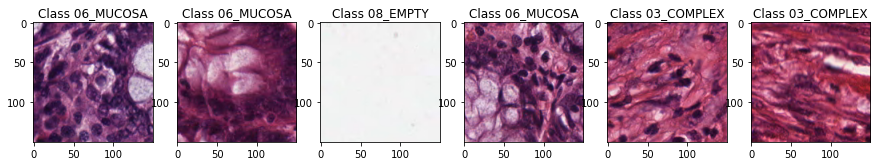

In [6]:
plot_samples(ds_train, num_samples=6)

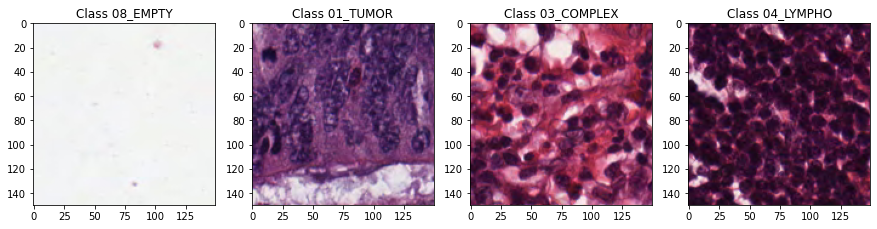

In [7]:
plot_samples(ds_validation, num_samples=4)

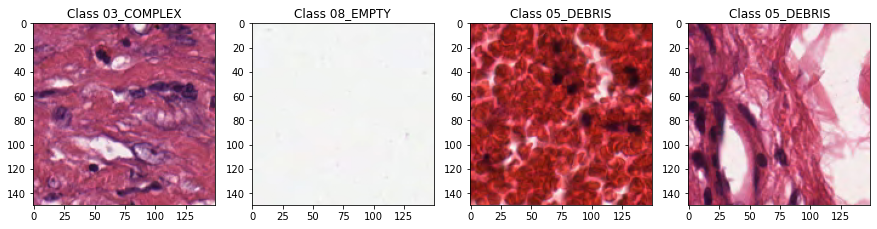

In [8]:
plot_samples(ds_test, num_samples=4)

## Define Model

Here's a Convolutional neural network model. 

In [9]:
inputs = tf.keras.layers.Input(shape=histology_dataset.get_shape())
conv = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(inputs)
conv = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(conv)
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv)

conv = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(maxpool)
conv = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv)
concat = tf.keras.layers.concatenate([maxpool, conv])
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(concat)

conv = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(maxpool)
conv = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv)
concat = tf.keras.layers.concatenate([maxpool, conv])
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(concat)

conv = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(maxpool)
conv = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv)
concat = tf.keras.layers.concatenate([maxpool, conv])
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(concat)

flat = tf.keras.layers.Flatten()(maxpool)
dense = tf.keras.layers.Dense(128)(flat)
drop = tf.keras.layers.Dropout(0.5)(dense)

predict = tf.keras.layers.Dense(histology_dataset.get_num_classes())(drop)

model = tf.keras.models.Model(inputs=[inputs], outputs=[predict])

opt = tf.keras.optimizers.Adam(0.0001)

model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=[tf.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 75, 75, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Train the model on the dataset

In [10]:
callbacks=[]

### Model Checkpoints

Save the model that performs best on the validation dataset

In [11]:
# Create a callback that saves the model
model_dir = "checkpoints"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_dir, 
                                                         save_best_only=True,
                                                         verbose=1)

callbacks.append(checkpoint_callback)

### Early Stopping

Stop training if the validation doesn't improve after a certain number of epochs

In [12]:
# Create callback for Early Stopping of training
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=8) # Stop once validation loss plateaus for patience epochs
callbacks.append(early_stopping_callback)

### Adding TensorBoard

Adding TensorBoard logs

## Call *fit* to train the model

In [13]:
epochs = 6   # Run for this many epochs - Increase if you have some time
history = model.fit(
        ds_train,
        epochs=epochs,     
        validation_data=ds_validation,
        callbacks=callbacks
        )


Epoch 1/6
34/34 [==============================] - ETA: 0s - loss: 3.2622 - sparse_categorical_accuracy: 0.3501
Epoch 00001: val_loss improved from inf to 1.07756, saving model to checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints/assets
34/34 [==============================] - 80s 2s/step - loss: 3.2622 - sparse_categorical_accuracy: 0.3501 - val_loss: 1.0776 - val_sparse_categorical_accuracy: 0.5600
Epoch 2/6
34/34 [==============================] - ETA: 0s - loss: 1.0025 - sparse_categorical_accuracy: 0.5664
Epoch 00002: val_loss improved from 1.07756 to 0.80141, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
34/34 [==============================] - 76s 2s/step - loss: 1.0025 - sparse_categorical_accuracy: 0.5664 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.7093
Epoch 3/6
34/34 [==============================] - ETA: 0s - loss: 0.8721 - sparse_catego

## Plot training curves

In [14]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

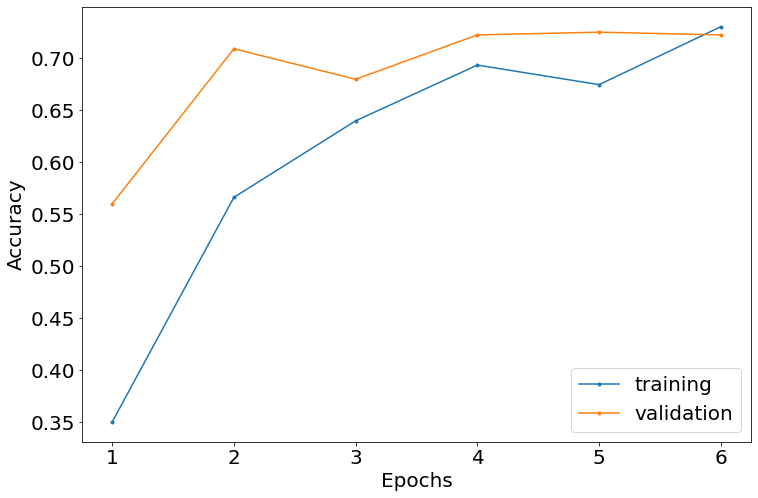

In [15]:
plt.figure(figsize=(12,8));
plt.plot(range(1,epochs+1), history.history['sparse_categorical_accuracy'], '.-');
plt.plot(range(1,epochs+1), history.history['val_sparse_categorical_accuracy'], '.-');
plt.legend(['training', 'validation'], fontsize=20);
plt.xticks(size=20);
plt.xlabel('Epochs', size=20);
plt.yticks(size=20);
plt.ylabel('Accuracy', size=20);


## Load the best model

In [17]:
print("Loading model that had the highest score on the validation dataset")
model = tf.keras.models.load_model(model_dir)

Loading model that had the highest score on the validation dataset


## Evaluate the best model on the test dataset

In [18]:
print("Evaluating the best model on the test dataset")
_, accuracy = model.evaluate(ds_test)
print("\nModel accuracy on test dataset = {:.1f}%".format(100.0*accuracy))

Evaluating the best model on the test dataset
6/6 [==============================] - 2s 307ms/step - loss: 0.7252 - sparse_categorical_accuracy: 0.7520

Model accuracy on test dataset = 75.2%


## Display some predictions on the test data

We grab a random subset of the test dataset and plot the image along with the ground truth label, the TensorFlow model prediction, and the OpenVINO model prediction.

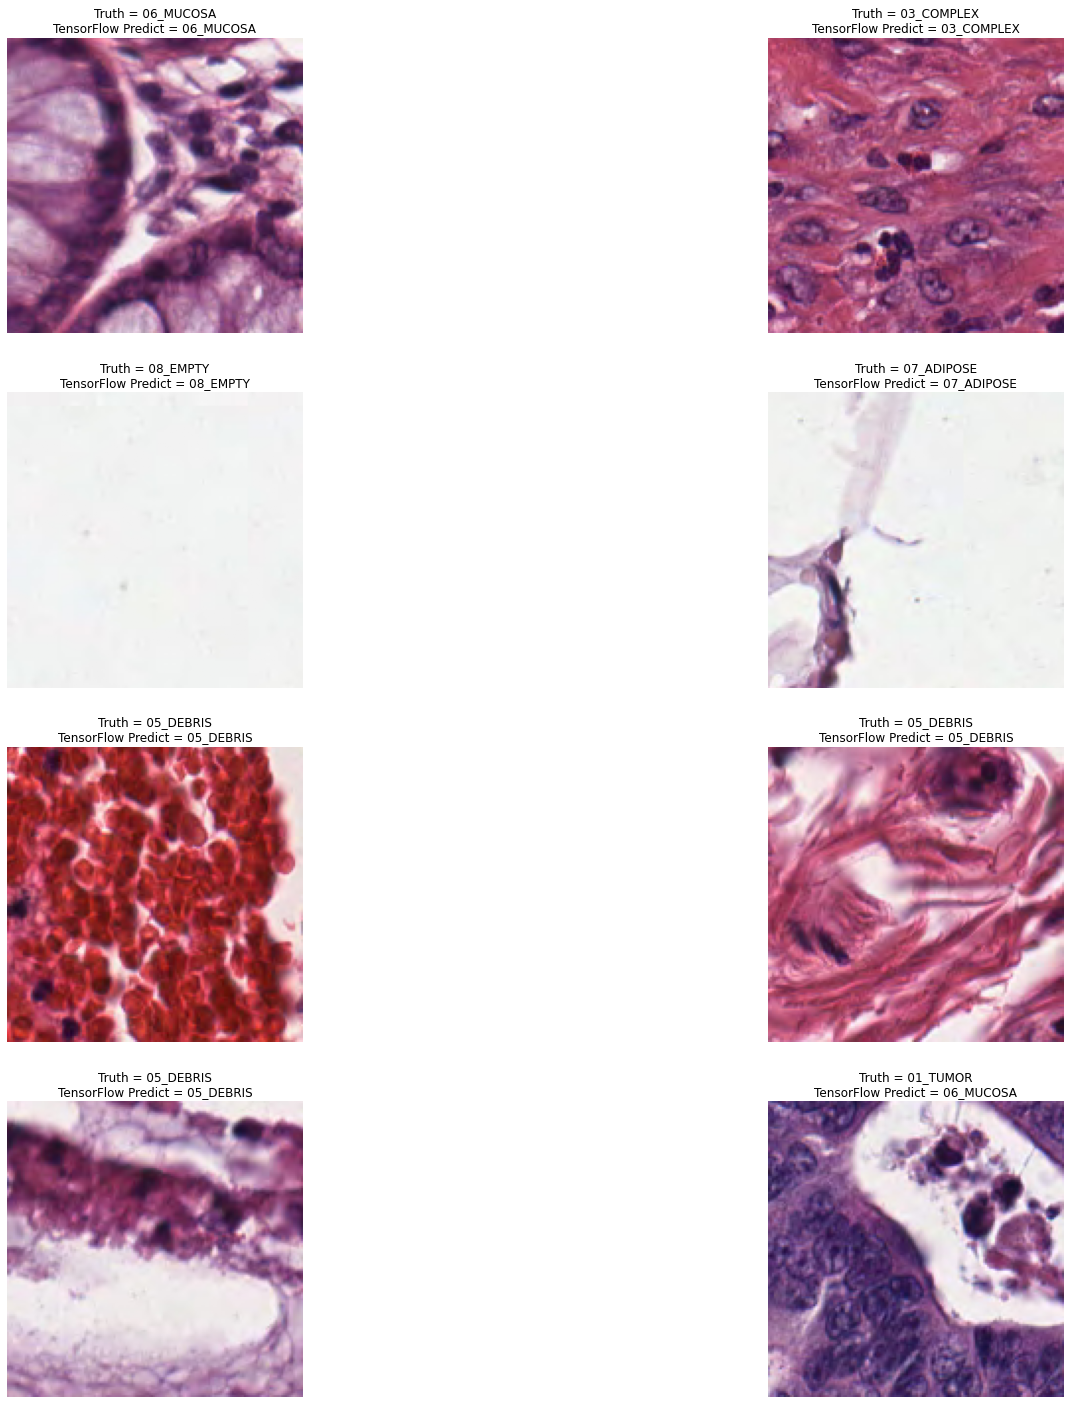

In [19]:
for image, label in ds_test.shuffle(100).take(1):
    num = 8 # len(label)
    cols = 2
    plt.figure(figsize=(25,25))
    
    for idx in range(num):
        
        plt.subplot(int(np.ceil(num/cols)), cols, idx+1)
        plt.imshow(image[idx])
        plt.axis("off")
        
        # TensorFlow model prediction
        tf_predict = CLASS_NAMES[model.predict(np.expand_dims(image[[idx]],0)).argmax()]
        
        plt.title("Truth = {}\nTensorFlow Predict = {}".format(CLASS_NAMES[label[idx]], tf_predict))
        